In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import sklearn.linear_model

## Task 1: Univariate Data Analysis for Data Quality Improvement

### Dataset
**This dataset is about forest fires in the Montesinho park in Portugal.** 

It contains meteorological data and other information that can be used to predict a fire in a certain area.

The dataset has 517 instances with 13 attributes. 

<details>
<summary>The features include:</summary>

- X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
- Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
- month - month of the year: "jan" to "dec" 
- day - day of the week: "mon" to "sun"
- FFMC - FFMC index from the FWI system: 18.7 to 96.20
- DMC - DMC index from the FWI system: 1.1 to 291.3 
- DC - DC index from the FWI system: 7.9 to 860.6 
- ISI - ISI index from the FWI system: 0.0 to 56.10
- temp - temperature in Celsius degrees: 2.2 to 33.30
- RH - relative humidity in %: 15.0 to 100
- wind - wind speed in km/h: 0.40 to 9.40 
- rain - outside rain in mm/m2 : 0.0 to 6.4 
- area - the burned area of the forest (in ha): 0.00 to 1090.84 

    this output variable is very skewed towards 0.0, thus it may make
    sense to model with the logarithm transform. 
</details>

[Source](https://www.kaggle.com/datasets/anitarostami/montesinho-forest-fire-prediction-dataset)

In [4]:
df = pd.read_csv('forestfires.csv')
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Dataset imperfections:
* Skewed distributions ✅  

* Outliers ✅

* Missing values ❌

* Potential noise and data entry errors ❌

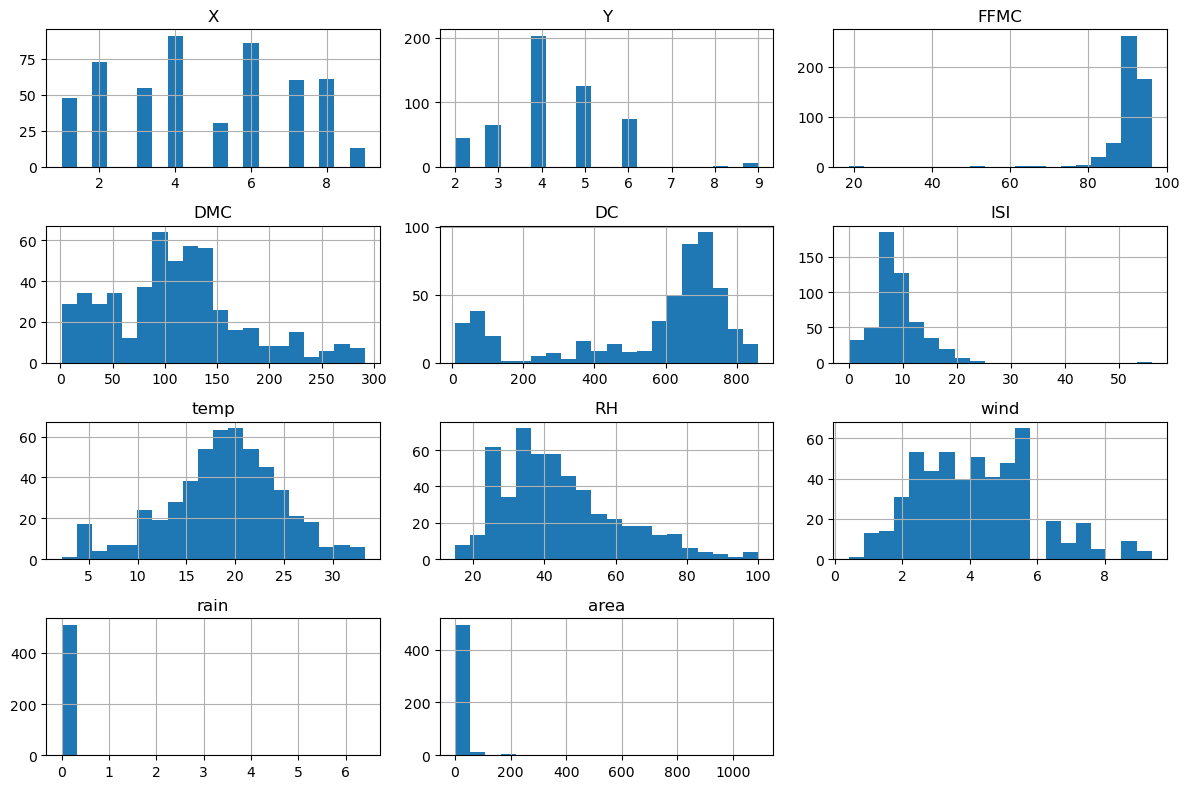

In [3]:
df.hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()

### Naive Linear Regression Model

In [4]:
df_without_categorical = df[[x for x in df.columns if x not in ['month', 'day']]]

X = df_without_categorical.iloc[:, :-1]
y_binary = (df_without_categorical['area'] > 0).astype(int)
y_regression = df_without_categorical['area']

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=42)

In [5]:
logistic_regression = sklearn.linear_model.LogisticRegression(
    max_iter=100, random_state=42,
    solver='liblinear'
)
logistic_regression.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [6]:
y_pred = logistic_regression.predict(X_test)

### Naive Classification Metrics
For this task, recall is more important (to detect a fire, if there is one) than precision, so the key metric is 

$$F_{beta}\text{-}score = \frac{(1+\beta^2)tp}{(1+\beta^2)tp + fp + \beta^2fn}$$

$$\text{with } \beta = 2$$

In [7]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

beta = 2
f1 = fbeta_score(y_test, y_pred, beta=2)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F{beta}-score:  {f1:.4f}")

Accuracy:  0.5513
Precision: 0.5437
Recall:    0.7089
F2-score:  0.6683


### EDA

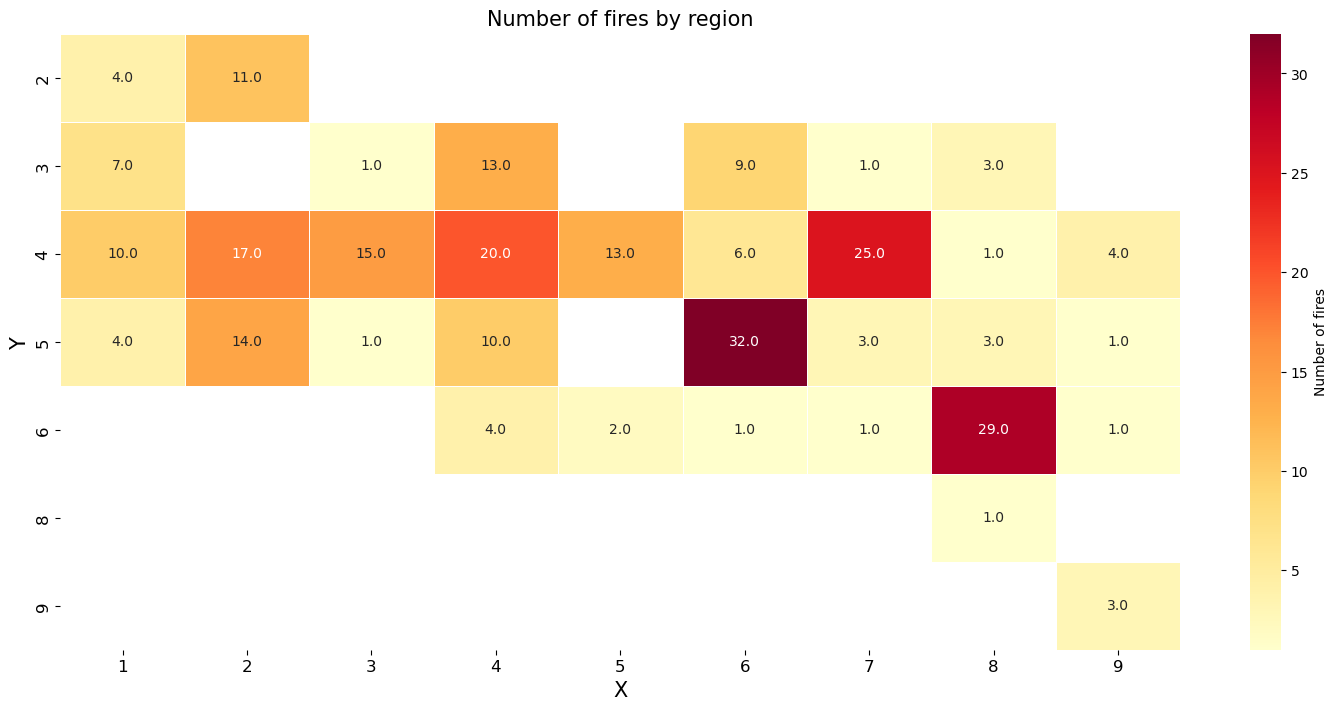

In [13]:
def XY(row):
    return (str(row['X']) + '|' + str(row['Y']))

vis = df
vis['X|Y'] = vis.apply(XY, axis = 1)
vis = vis[vis['area']!=0]
values = vis['X|Y'].to_list()
index = vis['area'].to_list()
size = pd.Series(values, index).value_counts().sort_index()

X, Y = [], []
for i in size.index:
    X.append(int(i.split('|')[0]))
    Y.append(int(i.split('|')[1]))
    
data = pd.DataFrame({'X': X, 'Y': Y, 'Number of fires': size})
heatmap_data = pd.pivot_table(data, values='Number of fires', index='Y', columns='X')

plt.figure(figsize = (14,8))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt=".1f", linewidths=.5, cbar_kws={'label': 'Number of fires'},
            xticklabels=1, yticklabels=1)

plt.xlabel('X', fontsize = 15)
plt.ylabel('Y', fontsize = 15)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.title('Number of fires by region', fontsize = 15)
plt.subplots_adjust(left=0, right=1)
plt.show()
df.drop('X|Y', axis=1 , inplace=True)